In [1]:
import zipfile
import pandas as pd
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from numpy import average as avg
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

# nltk.download('punkt')
# nltk.download('omw-1.4')
# nltk.download('stopwords')

# Read Training Data
Data source: https://www.kaggle.com/datasets/yasserh/twitter-tweets-sentiment-dataset

Columns:
1. textID - unique ID for each piece of text
2. text - the text of the tweet
3. sentiment - the general sentiment of the tweet

In [2]:
archive = zipfile.ZipFile("data.zip", "r")
data = pd.read_csv(archive.open("train_multiclass.csv"), encoding_errors="replace")
# drop preprocessed text of the dataset to perform our own preprocessing
data.drop(columns="selected_text", inplace=True)
# renaming columns for easier access
data.columns = ["id", "raw_text", "label"]
data.head()

,id,raw_text,label
0,cb774db0d1,"I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative
2,088c60f138,my boss is bullying me...,negative
3,9642c003ef,what interview! leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative


Number of tweets per label:

In [3]:
data["label"].value_counts()

neutral     11118
positive     8582
negative     7781
Name: label, dtype: int64

We change the label to numerical values for our model

In [4]:
data.loc[data["label"]=="negative", "label"] = 0
data.loc[data["label"]=="neutral", "label"] = 1
data.loc[data["label"]=="positive", "label"] = 2
data["label"] = data["label"].astype(int)

# Data Preprocessing

Turning everything into lowercase characters

In [5]:
data["raw_text"] = data["raw_text"].astype(str)
data["text"] = [entry.lower() for entry in data["raw_text"]]

Removing Stopwords (Common words like "my", "he", "is", ...)

In [6]:
stop = stopwords.words('english')
# we suspected 'no' and 'not' might be important words for the sentiment and don't want them to be removed
# (this indeed improved the model a little)
stop.remove("no")
stop.remove("not")

# stopwords are applied later by the tfidf vectorizer

Removing links, tags and several punctuations from tweets using regular expressions

In [7]:
data["text"] = data["text"].apply(lambda x: re.sub("http[s]?://\S+", "", x))
data["text"] = data["text"].apply(lambda x: re.sub("@\S+", "", x))
data["text"] = data["text"].apply(lambda x: re.sub("-|\.|,|'|\?|\!|`|\*", "", x))
# alternative try to remove special characters, but it deteriorated the model:
# data["text"] = data["text"].apply(lambda x: re.sub("[^a-z\s]", "", x))

Word-Stemming (Tested two stemmers)  

Naive Bayes works best without any stemmer  
Support Vector Machine works best with SnowballStemmer

In [8]:
# sstemmer = SnowballStemmer("english")
pstemmer = PorterStemmer()

data['text'] = data['text'].apply(lambda x: ' '.join([pstemmer.stem(word) for word in x.split()]))

Tokenize Words

In [9]:
data["text"] = [str(word_tokenize(entry)) for entry in data["text"]]

Our finished Data:

In [10]:
data.head()

,id,raw_text,label,text
0,cb774db0d1,"I`d have responded, if I were going",1,"['id', 'have', 'respond', 'if', 'i', 'were', '..."
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,0,"['sooo', 'sad', 'i', 'will', 'miss', 'you', 'h..."
2,088c60f138,my boss is bullying me...,0,"['my', 'boss', 'is', 'bulli', 'me']"
3,9642c003ef,what interview! leave me alone,0,"['what', 'interview', 'leav', 'me', 'alon']"
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",0,"['son', 'of', 'whi', 'couldnt', 'they', 'put',..."


# Model Training

Split Training/Test-Data and Transform into a vectorized form

In [11]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(data["text"], data["label"], test_size=0.2, random_state=42)

In [12]:
# define an apply the TF-IDF Vectorizer from sklearn
tfidf_vect = TfidfVectorizer(analyzer="word", strip_accents="unicode", stop_words=stop, min_df=10)
data_tfidf = tfidf_vect.fit_transform(data["text"])
x_train_tfidf = tfidf_vect.transform(x_train)
x_test_tfidf = tfidf_vect.transform(x_test)

In [13]:
print("# of Features (Words):", len(tfidf_vect.get_feature_names_out()))

# of Features (Words): 2197


Naive Bayes Classifier with cross-validation

In [14]:
NB = naive_bayes.MultinomialNB()
xval = model_selection.cross_validate(NB, data_tfidf, data["label"], cv=10)

# fit model on all data
NB.fit(data_tfidf, data["label"])

# Average Accuracy:
print(f"Average Accuracy of X-Val: {round(avg(xval['test_score'])*100, 2)}%")

Average Accuracy of X-Val: 64.54%


Support Vector Machine

Using GridSearch for hyperparameter-tuning

In [15]:
# parameters = [{
# 'kernel': ['poly', 'rbf', 'linear', 'sigmoid'], 
# 'C': [0.1, 0.75, 1, 2],
# 'degree' : [1,2,3,4,5],
# 'gamma' : ['scale', 'auto'],
# 'class_weight' : ['balanced', None],
# 'cache_size' : [2500],
# 'random_state' : [42],
# 'decision_function_shape' : ['ovo', 'ovr']
# }]

# clf = model_selection.GridSearchCV(
#         svm.SVC(), parameters, scoring='accuracy'
#     )
# clf.fit(x_train_tfidf, y_train)
# print(f"Best parameters: {clf.best_estimator_}")

Support Vector Machine Accuracy Score: 71.37%


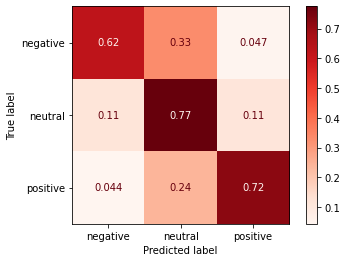

In [16]:
SVM = svm.SVC(C=1, kernel='linear', cache_size=2000, break_ties=False, decision_function_shape="ovr", random_state=42)
SVM.fit(x_train_tfidf, y_train)

predictions_SVM = SVM.predict(x_test_tfidf)

print(f"Support Vector Machine Accuracy Score: {round(accuracy_score(predictions_SVM, y_test)*100, 2)}%")
disp = ConfusionMatrixDisplay.from_predictions(y_test, predictions_SVM, normalize="true", display_labels=["negative", "neutral", "positive"], cmap="Reds")

# Test on self-labelled game related tweets

In [30]:
testdata = pd.read_excel(archive.open("game_tweets.xlsx"), usecols=["text", "label"])
# drop unlabelled data:
testdata = testdata.dropna()
testdata["label"] = testdata["label"].astype(int)

testdata

,label,text
0,0,"Okay, someone explain to me why Fall Guys and ..."
1,1,Look at this key I discovered on the Sea of Th...
2,1,Going Live ! Solo Slooping on the Sea of Thiev...
3,1,@KirkRooster Why isn’t gow boat travel as real...
4,2,@ItsCsteph @JAAY_ROCK_ Sea of Thieves let's yo...
...,...,...
980,0,How the fuck is Minecraft cross platform but G...
988,0,someone play fortnite or roblox with me i’m so...
1065,1,Grand Theft Auto V - PlayStation 5 #ps5 #gameg...
1574,1,Grand Theft Auto V - Playstation 1 (Gameplay)....


In [27]:
print(f"Negative Sentiment (0): {testdata['label'].value_counts()[0]} tweets")
print(f"Neutral Sentiment (1): {testdata['label'].value_counts()[1]} tweets")
print(f"Positive Sentiment (2): {testdata['label'].value_counts()[2]} tweets")

Negative Sentiment (0): 61 tweets
Neutral Sentiment (1): 428 tweets
Positive Sentiment (2): 199 tweets


Performing Preprocessing

In [31]:
# testdata["processed_test"] = data["raw_text"].astype(str)
testdata["text"] = [entry.lower() for entry in testdata["text"]]

testdata["text"] = testdata["text"].apply(lambda x: re.sub("http[s]?://\S+", "", x))
testdata["text"] = testdata["text"].apply(lambda x: re.sub("@\S+", "", x))
testdata["text"] = testdata["text"].apply(lambda x: re.sub("-|\.|,|'|\?|\!|`|\*", "", x))

data['text'] = data['text'].apply(lambda x: ' '.join([pstemmer.stem(word) for word in x.split()]))

testdata["text"] = [str(word_tokenize(entry)) for entry in testdata["text"]]

testdata.head()

,label,text
0,0,"['okay', 'someone', 'explain', 'to', 'me', 'wh..."
1,1,"['look', 'at', 'this', 'key', 'i', 'discovered..."
2,1,"['going', 'live', 'solo', 'slooping', 'on', 't..."
3,1,"['why', 'isn', '’', 't', 'gow', 'boat', 'trave..."
4,2,"['sea', 'of', 'thieves', 'lets', 'you', 'do', ..."


Naive Bayes Accuracy Score: 63.227%
Support Vector Machine Accuracy Score: 64.971%


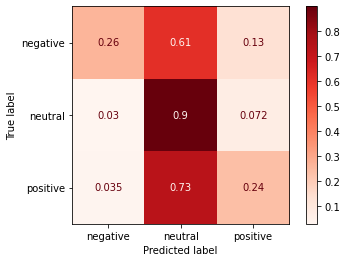

In [29]:
testdata_tfidf = tfidf_vect.transform(testdata["text"])
predictions_NB = NB.predict(testdata_tfidf)
predictions_SVM = SVM.predict(testdata_tfidf)
print(f"Naive Bayes Accuracy Score: {round(accuracy_score(predictions_NB, testdata['label'])*100, 3)}%")
print(f"Support Vector Machine Accuracy Score: {round(accuracy_score(predictions_SVM, testdata['label'])*100, 3)}%")
disp = ConfusionMatrixDisplay.from_predictions(testdata["label"], predictions_SVM, normalize="true", display_labels=["negative", "neutral", "positive"], cmap="Reds")

# Apply the best model on all our gaming related Tweets to get a result

In [21]:
gamedata = pd.read_excel(archive.open("game_tweets.xlsx"), usecols=["text"])

In [22]:
gamedata["text"] = [entry.lower() for entry in gamedata["text"]]

gamedata["text"] = gamedata["text"].apply(lambda x: re.sub("http[s]?://\S+", "", x))
gamedata["text"] = gamedata["text"].apply(lambda x: re.sub("@\S+", "", x))
gamedata["text"] = gamedata["text"].apply(lambda x: re.sub("-|\.|,|'|\?|\!|`|\*", "", x))

gamedata['text'] = gamedata['text'].apply(lambda x: ' '.join([pstemmer.stem(word) for word in x.split()]))

gamedata["text"] = [str(word_tokenize(entry)) for entry in gamedata["text"]]

gamedata_tfidf = tfidf_vect.transform(gamedata["text"])

gamedata.head()

,text
0,"['okay', 'someon', 'explain', 'to', 'me', 'whi..."
1,"['look', 'at', 'thi', 'key', 'i', 'discov', 'o..."
2,"['go', 'live', 'solo', 'sloop', 'on', 'the', '..."
3,"['whi', 'isn', '’', 't', 'gow', 'boat', 'trave..."
4,"['sea', 'of', 'thiev', 'let', 'you', 'do', 'it..."


In [23]:
predictions = SVM.predict(gamedata_tfidf)
gamedata.insert(1, "prediction", predictions)
gamedata["prediction"].value_counts()

1    1764
2     415
0     294
Name: prediction, dtype: int64